In [2]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

EPS = 1e-5  # define a small constant for numerical stability control

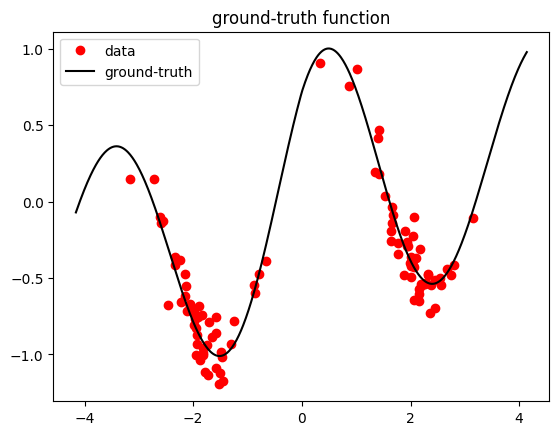

In [3]:
def ground_truth_func(x):
    return np.sin(x * math.pi / 2 + 0.8) * np.exp(-0.1 * np.abs(x)) + 0.1 * x

def gen_data(N_data, ground_truth_func, noise_std=None): 
    # generate the training dataset, note here we will make data into 2 clusters
    x1 = np.random.randn(int(N_data/2), 1) * 0.5 + 2.0
    x2 = np.random.randn(int(N_data/2), 1) * 0.5 - 2.0
    x = np.concatenate([x1, x2], axis=0)
    y = ground_truth_func(x)
    if noise_std is not None and noise_std > EPS:
        # assume homogeneous noise setting, i.e., "homoscedasticity"
        y += np.random.randn(y.shape[0], y.shape[1]) * noise_std
    return x, y

def normalise_data(x, mean, std):
    return (x - mean) / std

def unnormalise_data(x, mean, std):
    return x * std + mean

class regression_data(Dataset):
     def __init__(self, x, y, normalise=True):
         super(regression_data, self).__init__()
         self.update_data(x, y, normalise)

     def __len__(self):
         return self.x.shape[0]

     def __getitem__(self, index):
         x = torch.tensor(self.x[index]).float()
         y = torch.tensor(self.y[index]).float()
         return x, y

     def update_data(self, x, y, normalise=True, update_stats=True):
         assert x.shape[0] == y.shape[0]
         self.x = x
         self.y = y
         # normalise data
         self.normalise = normalise
         if update_stats:
             self.x_mean = self.x.mean(0) if normalise else 0.0
             self.x_std = self.x.std(0) if normalise else 1.0
             self.y_mean = self.y.mean(0) if normalise else 0.0
             self.y_std = self.y.std(0) if normalise else 1.0
         if self.normalise:
             self.x = normalise_data(self.x, self.x_mean, self.x_std)
             self.y = normalise_data(self.y, self.y_mean, self.y_std)

N_data = 100
noise_std = 0.1
x_train, y_train = gen_data(N_data, ground_truth_func, noise_std)
dataset = regression_data(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

# plot the training data and ground truth
x_test = np.arange(np.min(x_train) - 1.0, np.max(x_train)+1.0, 0.01)[:, np.newaxis]
y_test = ground_truth_func(x_test)
plt.plot(x_train, y_train, 'ro', label='data')
plt.plot(x_test, y_test, 'k-', label='ground-truth')
plt.legend()
plt.title('ground-truth function')
plt.show()

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def gauss_loglik(y, y_pred, log_noise_var):
    # y should have shape as (batch_size, y_dim)
    # y_pred should have shape as (batch_size, y_dim) or (K, batch_size, y_dim)
    # where K is the number of MC samples
    # this function should return per-data loss of shape (batch_size,) or (K, batch_size)
    ### begin of your code ###
    # hint: consult with your textbook or wikipedia for the Gaussian distribution form
    l2_dist=(y-y_pred).pow(2).sum(-1)
    ll = -0.5 * (log_noise_var + math.log(2 * math.pi) + l2_dist * torch.exp(-log_noise_var))

    ### end of your code ###
    return ll

# we assume a Gaussian likelihood with homogeneuous noise
log_noise_var = nn.Parameter(torch.ones(size=(), device=device)*-3.0)

data_loss_func = lambda y, y_pred: -gauss_loglik(y, y_pred, log_noise_var)
nll = data_loss_func(y, y_pred).mean()